#Notebook Objectives
The aim of this notebook is to tune the XGB regression model by optimyzing the hyperparameters. The model tuning will be done by means of using K-fold Gridsearch CV. As this is a computationally expensive step, we have used DASK to access additional computational resources.

In [ ]:
# Import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# To work with numpy arrays
import numpy as np
# ML model building, training and testing
import sklearn
# Kfold split
from sklearn.model_selection import KFold
# Build ML pipeline
from sklearn.pipeline import Pipeline
# Liner regression model building
from sklearn.linear_model import LinearRegression
# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures
# sklearn included transformer
from sklearn.preprocessing import QuantileTransformer
# to split data into test and train
from sklearn.model_selection import train_test_split
# Scaling transform for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# To run PCA feature reduction
from sklearn.decomposition import PCA
# XGBoost model
from xgboost import XGBRegressor,XGBClassifier
# Random forest regressor
from sklearn.ensemble import RandomForestRegressor
# for regression error calculation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
# for regression r2 score calculation
from sklearn.metrics import r2_score
# for regression mse score calculation
from sklearn.metrics import mean_squared_error
# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# To transform the target variable into a normal distribution
from sklearn.compose import TransformedTargetRegressor
# visualisation
from matplotlib import pyplot

## Data Loading

In [ ]:
#import csv file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
barstow2017 = pd.read_csv('/content/drive/barstow_2017.csv')

In [ ]:
barstow2017.head()

,X,Y,aspect,slope,NDVI,MNDWI,SR_B4,SR_B7,SR_B6,SAVI,ST_B10,NDMI,SR_B3,EVI,MSAVI,MSI,SR_B2,SR_B5,smi
0,478350.0,3845070.0,340,2,0.389658,-0.379756,0.155328,0.221822,0.299345,0.294846,311.079090,0.083173,0.134565,0.302484,0.277401,0.846426,0.086193,0.353658,0.198108
1,478380.0,3845070.0,350,2,0.334047,-0.359627,0.168692,0.231310,0.302287,0.252183,311.038074,0.055669,0.142375,0.253876,0.234891,0.894534,0.091143,0.337927,0.194729
2,478410.0,3845070.0,358,2,0.293744,-0.356553,0.169462,0.233648,0.297613,0.215787,311.014148,0.021076,0.141165,0.214680,0.198167,0.958718,0.091417,0.310428,0.194825
3,478440.0,3845070.0,0,2,0.326162,-0.374574,0.168197,0.237278,0.308200,0.244431,311.003894,0.035707,0.140230,0.244199,0.226916,0.931048,0.089768,0.331025,0.195598
4,478470.0,3845070.0,345,1,0.355590,-0.379177,0.167400,0.237003,0.314580,0.271805,311.000476,0.056343,0.141605,0.273777,0.254934,0.893325,0.089272,0.352145,0.197915


In [ ]:
X = barstow2017.drop('smi',1)
y = barstow2017['smi']

<ipython-input-6-798c2ffe3b12>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = barstow2017.drop('smi',1)


In [ ]:
X = X[['aspect','slope','NDMI','SR_B5','SAVI','EVI','NDVI','ST_B10'
                                ,'MNDWI','SR_B7','SR_B6','MSAVI']]

In [ ]:
#Splitting the data into test (25%) and train (75%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Gridsearch (XGB hyperparameter tuning) using DASK

In [ ]:
pip install "dask[complete]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.7 MB/s eta 0:00:00


In [ ]:
pip install dask-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 8.6 MB/s eta 0:00:00


In [ ]:
import joblib
from dask.distributed import Client

## XGB model tuning using a pipeline in DASK
The reason why to pre-process and tune the model with k-fold split in a pipeline is stated here to avoid leakage https://towardsdatascience.com/pre-process-data-with-pipeline-to-prevent-data-leakage-during-cross-validation-e3442cca7fdc

In [ ]:
# Instantiate pipeline
pipe = Pipeline([
               # ('standard_scaler', StandardScaler())
              #, ('PCA', PCA(n_components= 6)) ,
              ('xgb', XGBRegressor(random_state= 42))
              ])

In [ ]:
param_grid = {
            #'PCA__n_components':[6],
            'xgb__max_depth': [5,10,15,20],
            'xgb__colsample_bylevel': [0.5,0.7,0.8],
            'xgb__learning_rate': [0.001,0.01,0.1],
            'xgb__n_estimators': [100]
            }

In [ ]:
import dask_ml.model_selection as dcv

In [ ]:
client = Client() # start a local Dask client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33283
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41299'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37271'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:42759', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42759
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:42726
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:43067', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43067
INFO:distributed.core:Sta

In [ ]:
%%time
#using grid search cv to find the optimal parameters
# regr = RandomForestRegressor( random_state= RANDOM_STATE)


with joblib.parallel_backend('dask'):
  #g_search = GridSearchCV(estimator = regr, scoring= 'r2', param_grid= param_grid,  n_jobs = -1 ,cv=10)
  #g_search.fit(X_train,y_train)
  grid = dcv.GridSearchCV(pipe, param_grid, cv = 3, n_jobs = -1, scoring = 'r2')
  grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

{'xgb__colsample_bylevel': 0.5,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 15,
 'xgb__n_estimators': 100}

In [ ]:
grid.best_score_

0.855197365388947

In [ ]:
df_result = pd.DataFrame(grid.cv_results_)
df_result

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,param_xgb__colsample_bylevel,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators
0,"{'xgb__colsample_bylevel': 0.5, 'xgb__learning...",1.530853,0.534262,0.112870,0.035838,0.097868,0.099659,0.097430,0.098319,0.000964,36,0.5,0.001,5,100
1,"{'xgb__colsample_bylevel': 0.5, 'xgb__learning...",8.152666,0.657224,0.272539,0.023478,0.130260,0.132414,0.130532,0.131069,0.000958,33,0.5,0.001,10,100
2,"{'xgb__colsample_bylevel': 0.5, 'xgb__learning...",26.625648,0.982463,2.057851,0.466552,0.137720,0.140608,0.138240,0.138856,0.001257,30,0.5,0.001,15,100
3,"{'xgb__colsample_bylevel': 0.5, 'xgb__learning...",60.306608,0.452592,2.770724,0.776769,0.138190,0.141301,0.138749,0.139413,0.001354,29,0.5,0.001,20,100
4,"{'xgb__colsample_bylevel': 0.5, 'xgb__learning...",1.432679,0.318557,0.116975,0.042055,0.555428,0.556073,0.554261,0.555254,0.000750,24,0.5,0.01,5,100
5,"{'xgb__colsample_bylevel': 0.5, 'xgb__learning...",6.733455,0.885701,0.320936,0.089676,0.673926,0.678190,0.674675,0.675597,0.001859,21,0.5,0.01,10,100
6,"{'xgb__colsample_bylevel': 0.5, 'xgb__learning...",28.955435,1.372971,1.814682,0.558468,0.699232,0.705083,0.700360,0.701558,0.002535,18,0.5,0.01,15,100
7,"{'xgb__colsample_bylevel': 0.5, 'xgb__learning...",64.866616,1.255868,3.011092,1.040076,0.699809,0.705926,0.701421,0.702386,0.002589,17,0.5,0.01,20,100
8,"{'xgb__colsample_bylevel': 0.5, 'xgb__learning...",0.949491,0.035868,0.115932,0.026345,0.810301,0.800492,0.808927,0.806573,0.004337,12,0.5,0.1,5,100
9,"{'xgb__colsample_bylevel': 0.5, 'xgb__learning...",4.967914,0.416912,0.525132,0.115413,0.857142,0.851247,0.856068,0.854819,0.002563,3,0.5,0.1,10,100


In [ ]:
df_result.columns

Index(['params', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'param_xgb__colsample_bylevel',
       'param_xgb__learning_rate', 'param_xgb__max_depth',
       'param_xgb__n_estimators'],
      dtype='object')

<Axes: xlabel='mean_fit_time', ylabel='param_xgb__max_depth'>

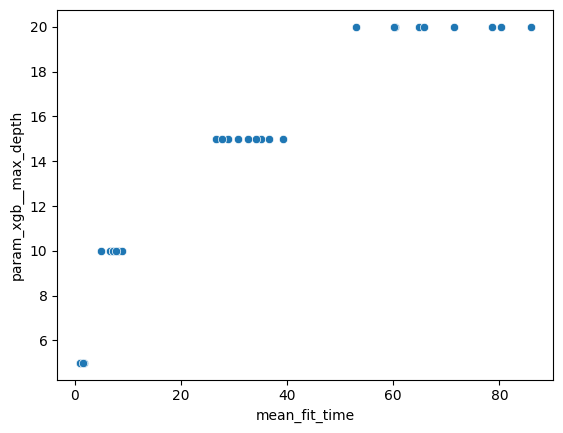

In [ ]:
sns.scatterplot(x="mean_fit_time", y="param_xgb__max_depth", data=df_result)

<Axes: xlabel='split0_test_score', ylabel='param_xgb__learning_rate'>

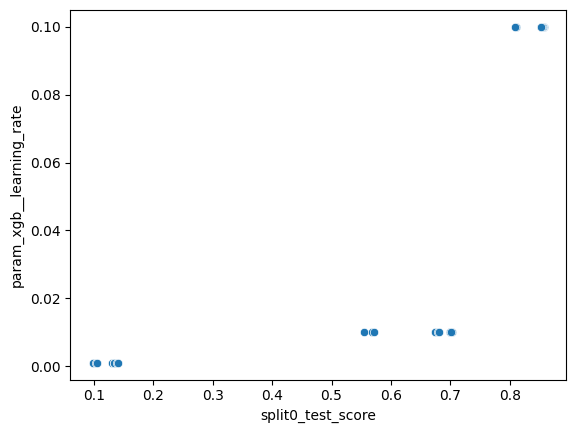

In [ ]:
sns.scatterplot(x="split0_test_score", y="param_xgb__learning_rate", data=df_result)

### Model Tuning using Three Rivers 22 data

In [ ]:
threerivers_22 = pd.read_csv('/content/drive/MyDrive/Capstone/Data/threerivers_2022.csv')

In [ ]:
X = threerivers_22.drop('smi',1)
y = threerivers_22['smi']

<ipython-input-17-e7511d9e06fd>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = threerivers_22.drop('smi',1)


In [ ]:
X = X[['aspect','slope','NDMI','SR_B5','MSI','SAVI','EVI','NDVI','ST_B10'
                                ,'MNDWI','SR_B7','SR_B6','MSAVI']]

In [ ]:
#Splitting the data into test (25%) and train (75%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
%%time
#using grid search cv to find the optimal parameters
# regr = RandomForestRegressor( random_state= RANDOM_STATE)


with joblib.parallel_backend('dask'):
  #g_search = GridSearchCV(estimator = regr, scoring= 'r2', param_grid= param_grid,  n_jobs = -1 ,cv=10)
  #g_search.fit(X_train,y_train)
  grid = dcv.GridSearchCV(pipe, param_grid, cv = 2, n_jobs = -1, scoring = 'r2')
  grid.fit(X_train, y_train)

CPU times: user 30.4 s, sys: 3.91 s, total: 34.3 s
Wall time: 7min 33s


In [ ]:
grid.best_params_

{'xgb__colsample_bylevel': 0.8,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 10,
 'xgb__n_estimators': 100}

In [ ]:
grid.best_score_

0.9815606027732697

### Model Tuning using Mariposa 21 data

In [ ]:
mariposa_21 = pd.read_csv('https://github.com/belalabouzaid/siads699_team13_collab/raw/main/Data/mariposa_2021.csv')

In [ ]:
X = mariposa_21.drop('smi',1)
y = mariposa_21['smi']

<ipython-input-26-4d28256c0d64>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = mariposa_21.drop('smi',1)


In [ ]:
X = X[['aspect','slope','NDMI','SR_B5','MSI','SAVI','EVI','NDVI','ST_B10'
                                ,'MNDWI','SR_B7','SR_B6','MSAVI']]

In [ ]:
#Splitting the data into test (25%) and train (75%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
%%time
#using grid search cv to find the optimal parameters
# regr = RandomForestRegressor( random_state= RANDOM_STATE)


with joblib.parallel_backend('dask'):
  #g_search = GridSearchCV(estimator = regr, scoring= 'r2', param_grid= param_grid,  n_jobs = -1 ,cv=10)
  #g_search.fit(X_train,y_train)
  grid = dcv.GridSearchCV(pipe, param_grid, cv = 2, n_jobs = -1, scoring = 'r2')
  grid.fit(X_train, y_train)

CPU times: user 1min 7s, sys: 9.02 s, total: 1min 16s
Wall time: 17min 20s


In [ ]:
grid.best_params_

{'xgb__colsample_bylevel': 0.8,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 10,
 'xgb__n_estimators': 100}

In [ ]:
grid.best_score_

0.8245801889809902